In [130]:
import pandas as pd
import numpy as np
import tqdm
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.stattools import adfuller
import statsmodels.api as sm
import statsmodels.tsa.api as smt
from statsmodels.tsa.stattools import adfuller
import matplotlib.pyplot as plt
from scipy.stats import boxcox
from math import sqrt

### 1. 'monthly-us-auto-registration-tho.csv' 

In [131]:
df_auto_reg = pd.read_csv('monthly-us-auto-registration-tho.csv', delimiter=';')

In [132]:
df_auto_reg.head(2)

,Month,Monthly U.S. auto registration (thousands) 1947 ? 1968
0,1947-01,209
1,1947-02,214


In [133]:
df_auto_reg.tail(2)

,Month,Monthly U.S. auto registration (thousands) 1947 ? 1968
262,1968-11,757
263,1968-12,977


In [134]:
df_auto_reg.columns = ['Month', 'Registrations']

In [135]:
df_auto_reg.head()

,Month,Registrations
0,1947-01,209
1,1947-02,214
2,1947-03,265
3,1947-04,290
4,1947-05,287


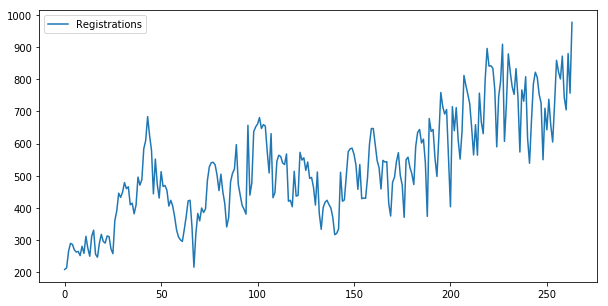

In [136]:
fig = df_auto_reg.plot(figsize=(10,5))

In [137]:
from statsmodels.tsa.stattools import adfuller

In [138]:
################
 # Dickey-Fuller
##################
def test_stationarity(timeseries):
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
    for [key, value] in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)

In [139]:
def tsplot(y, lags=None, figsize=(14, 8), style='bmh'):
    test_stationarity(y)
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
    with plt.style.context(style):
        plt.figure(figsize=figsize)
        layout = (5, 1)
        ts_ax = plt.subplot2grid(layout, (0, 0), rowspan=2)
        acf_ax = plt.subplot2grid(layout, (2, 0))
        pacf_ax = plt.subplot2grid(layout, (3, 0))
        qq_ax = plt.subplot2grid(layout, (4, 0))

        y.plot(ax=ts_ax, color='blue', label='Or')
        ts_ax.set_title('Original')

        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax, alpha=0.05)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax, alpha=0.05)
        sm.qqplot(y, line='s', ax=qq_ax)
        
        plt.tight_layout()
    return

In [140]:
test_stationarity(df_auto_reg['Registrations'])

Results of Dickey-Fuller Test:
Test Statistic                  -1.225039
p-value                          0.662733
#Lags Used                      15.000000
Number of Observations Used    248.000000
Critical Value (1%)             -3.456996
Critical Value (5%)             -2.873266
Critical Value (10%)            -2.573019
dtype: float64


Ряд нестационарен, требуются преобразования.

Для начала нормализуем дисперсию.

In [141]:
from scipy.stats import boxcox
from scipy.special import inv_boxcox

In [142]:
df_auto_reg['Registrations_box'], lambd = boxcox(df_auto_reg['Registrations'])

In [143]:
lambd

0.49846845102590315

Возьмем сезонную разницу

In [144]:
df_auto_reg['Registrations_box_season'] = df_auto_reg['Registrations_box'].diff(12)

In [145]:
df_auto_reg['Registrations_box_season_diff_1'] = df_auto_reg['Registrations_box_season'].diff()

In [146]:
test_stationarity(df_auto_reg['Registrations_box_season_diff_1'].dropna())

Results of Dickey-Fuller Test:
Test Statistic                -6.604213e+00
p-value                        6.618944e-09
#Lags Used                     1.200000e+01
Number of Observations Used    2.380000e+02
Critical Value (1%)           -3.458128e+00
Critical Value (5%)           -2.873762e+00
Critical Value (10%)          -2.573283e+00
dtype: float64


In [147]:
def inverse_transform(series, df):
    """
    Функция для обратного преобразования стационарного ряда к исходному.
    """
    series = np.where(series.notna(), series, df_auto_reg['Registrations_box_season_diff_1'].dropna().reset_index(drop=True))
    series = pd.Series([None]*13).append(pd.Series(series)).reset_index(drop=True)
    box_season = series + df['Registrations_box_season'].shift(1)
    box_season[12] = df['Registrations_box_season'][12]
    season = box_season + df['Registrations_box'].shift(12)
    season[:12] = df['Registrations_box'][:12]
    box = inv_boxcox(season.astype(float), lambd)   
    return box

In [148]:
# нестационарный ряд
series_nst = df_auto_reg['Registrations']
# стационарный ряд
series_st = df_auto_reg['Registrations_box_season_diff_1'].dropna()

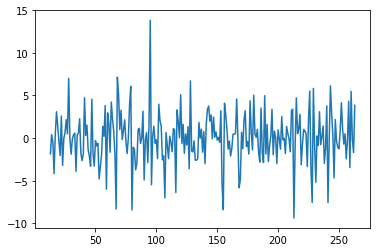

In [149]:
fig = plt.plot(series_st)

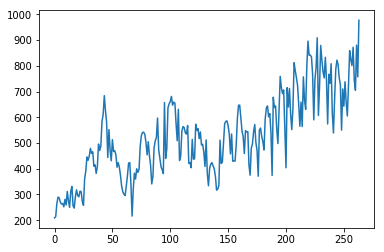

In [150]:
fig = plt.plot(series_nst)

In [151]:
series_st.reset_index(drop=True, inplace=True)

In [152]:
len(series_nst), len(series_st)

(264, 251)

In [153]:
# возьмем в качестве тестового ряда период в 6 месяцев
train_st, test_st = series_st[:-6], series_st[-6:]
train_nst, test_nst = series_nst[:-6], series_nst[-6:]

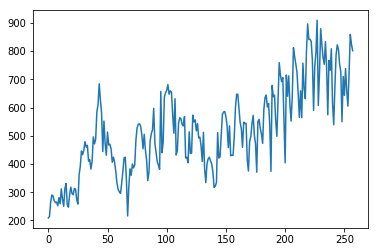

In [154]:
plt.plot(train_nst)

In [155]:
from sklearn.metrics import mean_squared_error

# I. Стационарный ряд

#### 1.1 ARIMA

/home/sergey/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/sergey/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/home/sergey/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


aic: 1211.20710 | order: (3, 0, 4)
Results of Dickey-Fuller Test:
Test Statistic                -6.422322e+00
p-value                        1.778951e-08
#Lags Used                     1.200000e+01
Number of Observations Used    2.320000e+02
Critical Value (1%)           -3.458855e+00
Critical Value (5%)           -2.874080e+00
Critical Value (10%)          -2.573453e+00
dtype: float64


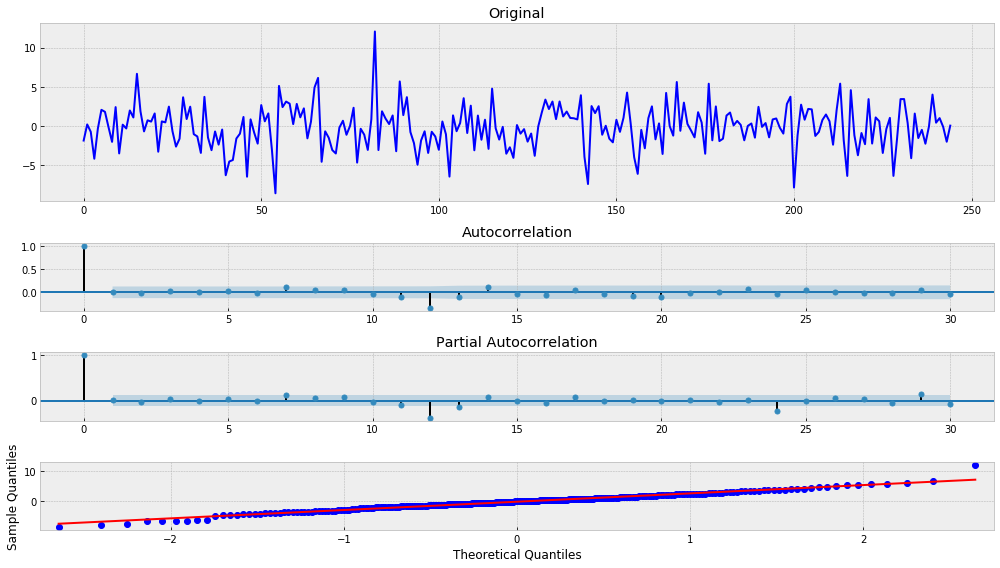

In [27]:
best_aic_st = np.inf 
best_order_st = None
best_mdl_st = None

for i in range(5):
    for d in range(5):
        for j in range(5):
            try:
                tmp_mdl = smt.ARIMA(train_st, order=(i,d,j)).fit(method='mle', trend='nc')
                tmp_aic = tmp_mdl.aic
                if tmp_aic < best_aic_st:
                    best_aic_st = tmp_aic
                    best_order_st = (i, d, j)
                    best_mdl_st = tmp_mdl
            except: continue


print('aic: {:6.5f} | order: {}'.format(best_aic_st, best_order_st))


tsplot(best_mdl_st.resid, lags=30)

Остатки стационарны

In [28]:
best_order_st, best_aic_st

((3, 0, 4), 1211.2071017418273)

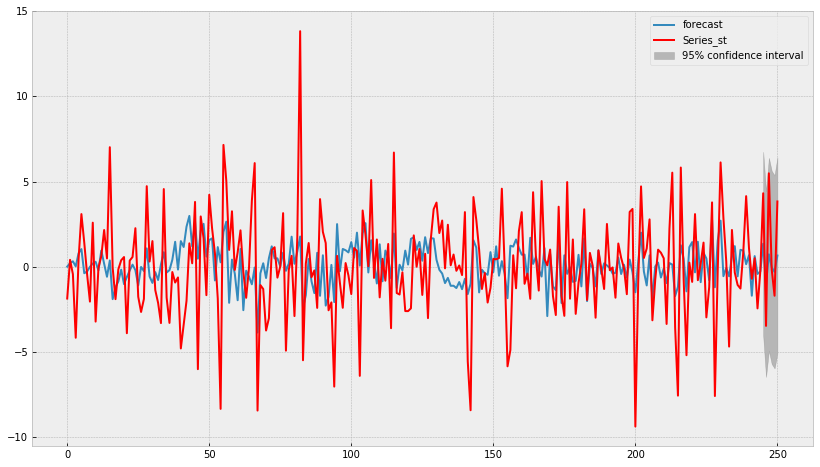

In [29]:
with plt.style.context('bmh'):
    plt.figure(figsize=(14,8))
    ax = plt.axes()
    best_mdl_st.plot_predict(0, len(train_st)+5, plot_insample=False, ax=ax)
    plt.plot(series_st, color='red', label='Series_st')
    plt.legend()
    plt.show()

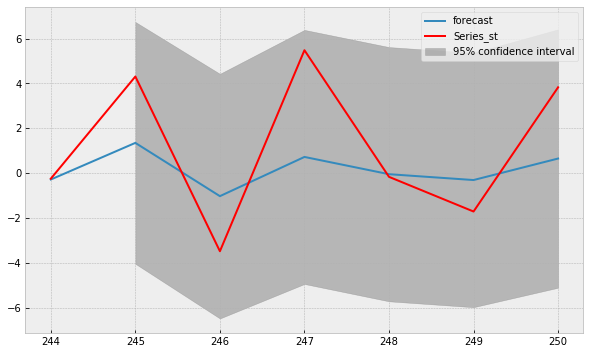

In [30]:
with plt.style.context('bmh'):
    plt.figure(figsize=(10,6))
    ax = plt.axes()
    best_mdl_st.plot_predict(len(train_st)-1, len(train_st)+5, plot_insample=False, ax=ax)
    plt.plot(series_st[-7:], color='red', label='Series_st')
    plt.legend()
    plt.show()

In [31]:
predictions_arima_st = best_mdl_st.predict(0, len(series_st)-1)

In [32]:
len(predictions_arima_st), len(series_st)

(251, 251)

In [34]:
# посмотрим на график предсказаний в сравнении с исходным временным рядом
res_arima = inverse_transform(predictions_arima_st, df_auto_reg)

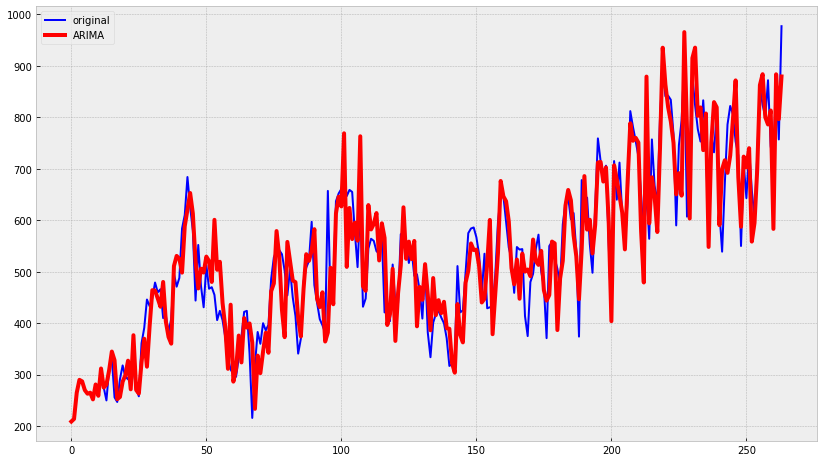

In [35]:
with plt.style.context('bmh'):
    plt.figure(figsize=(14, 8))
    plt.plot(series_nst, color='blue',label='original')
    plt.plot(res_arima, color='red', linewidth='4', label='ARIMA')
    plt.legend()

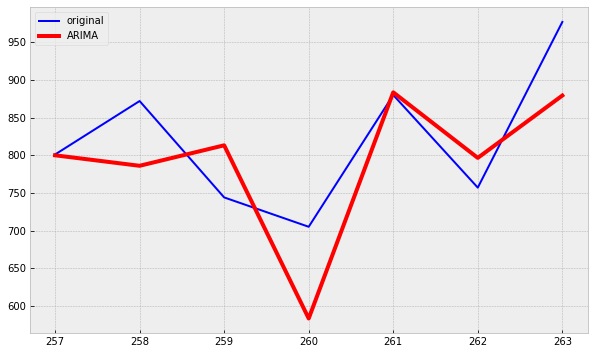

In [221]:
with plt.style.context('bmh'):
    plt.figure(figsize=(10, 6))
    plt.plot(series_nst[-7:], color='blue',label='original')
    plt.plot(res_arima[-7:], color='red', linewidth='4', label='ARIMA')
    plt.legend()

In [37]:
arima_errors_st = mean_squared_error(test_nst, res_arima[-6:])
print(f'MSE на тестовом ряде для модели ARIMA и исходного ряда: {arima_errors_st:.2f}')

MSE на тестовом ряде для модели ARIMA и исходного ряда: 6354.76


Предсказания получились лучше, чем у моделей MA

#### 1.2.  GARCH

In [168]:
from arch import arch_model

In [189]:
# Now we can fit the arch model using the best fit arima model parameters
p_ = best_order_st[0]
o_ = best_order_st[1]
q_ = best_order_st[2]

# Using student T distribution usually provides better fit
am = arch_model(series_st, p=p_, o=o_, q=q_, dist='StudentsT')
res = am.fit(update_freq=5, disp='off')
print(res.summary())

                            Constant Mean - GARCH Model Results                            
Dep. Variable:     Registrations_box_season_diff_1   R-squared:                      -0.000
Mean Model:                          Constant Mean   Adj. R-squared:                 -0.000
Vol Model:                                   GARCH   Log-Likelihood:               -625.304
Distribution:             Standardized Student's t   AIC:                           1270.61
Method:                         Maximum Likelihood   BIC:                           1305.86
                                                     No. Observations:                  251
Date:                             Sun, May 26 2019   Df Residuals:                      241
Time:                                     15:04:51   Df Model:                           10
                               Mean Model                               
                 coef    std err          t      P>|t|  95.0% Conf. Int.
--------------------------

Results of Dickey-Fuller Test:
Test Statistic                -6.604213e+00
p-value                        6.618944e-09
#Lags Used                     1.200000e+01
Number of Observations Used    2.380000e+02
Critical Value (1%)           -3.458128e+00
Critical Value (5%)           -2.873762e+00
Critical Value (10%)          -2.573283e+00
dtype: float64


/home/sergey/anaconda3/lib/python3.7/site-packages/statsmodels/regression/linear_model.py:1283: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


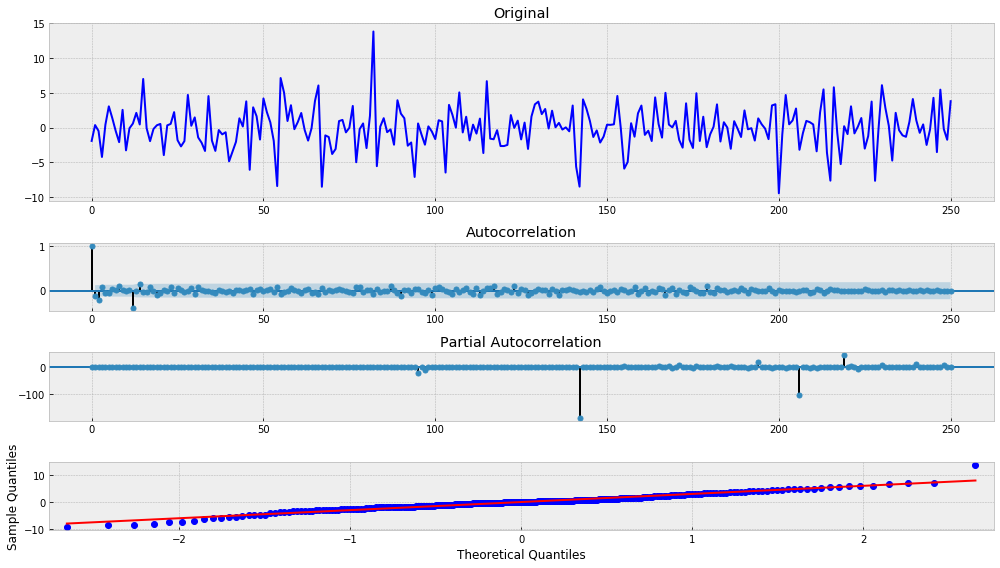

In [190]:
tsplot(res.resid)

Остатки стационарны

#### 1.3 Linear Regression

In [199]:
series = pd.read_csv('monthly-us-auto-registration-tho.csv', delimiter=';')
series.columns = ['Month', 'Registrations']
series.head()

,Month,Registrations
0,1947-01,209
1,1947-02,214
2,1947-03,265
3,1947-04,290
4,1947-05,287


In [212]:
def prepareData(data, lag_start=5, lag_end=20, test_size=6):
    
    data = data.copy()
    
    # считаем индекс в датафрейме, после которого начинается тестовый отрезок
    test_index = -test_size
    
    # добавляем лаги исходного ряда в качестве признаков
    for i in range(lag_start, lag_end):
        data["lag_{}".format(i)] = data['Registrations'].shift(i)
        
    data = data.dropna()
    data = data.reset_index(drop=True)
    data = data.drop(["Month"], axis=1)
     
    # разбиваем весь датасет на тренировочную и тестовую выборку
    X_train = data.iloc[:test_index].drop(['Registrations'], axis=1)
    y_train = data.iloc[:test_index]['Registrations']
    X_test = data.iloc[test_index:].drop(['Registrations'], axis=1)
    y_test = data.iloc[test_index:]['Registrations']
    
    return X_train, X_test, y_train, y_test

In [213]:
X_train, X_test, y_train, y_test = prepareData(series, lag_start=1, lag_end=20, test_size=6)

In [216]:
from sklearn.linear_model import LinearRegression

In [217]:
lr = LinearRegression()
lr.fit(X_train, y_train)
prediction = lr.predict(X_test)

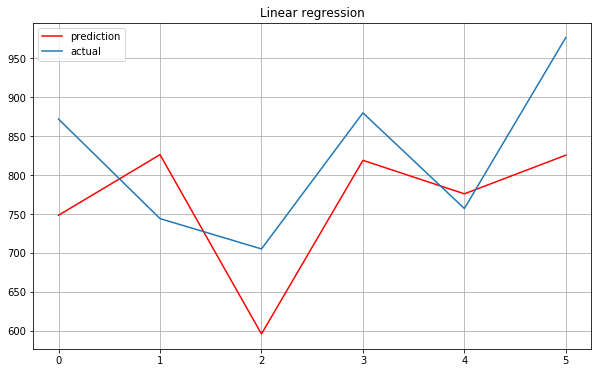

In [219]:
plt.figure(figsize=(10, 6))
plt.plot(prediction, "r", label="prediction")
plt.plot(y_test.values, label="actual")
plt.legend(loc="best")
plt.title("Linear regression")
plt.grid(True);

In [220]:
lr_errors_st = mean_squared_error(prediction, y_test.values)
print(f'MSE на тестовом ряде для модели Linear Regression и исходного ряда: {lr_errors_st:.2f}')

MSE на тестовом ряде для модели Linear Regression и исходного ряда: 10173.42


# II. Нестационарный ряд

#### 2.1 ARIMA

/home/sergey/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/sergey/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/sergey/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/sergey/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/tsatools.py:607: RuntimeWarning: invalid value encountered in true_divide
  (1+np.exp(-params))).copy()
/home/sergey/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/tsatools.py:609: RuntimeWarning: invalid value encountered in true_divide
  (1+np.exp(-params))).copy()
/home/sergey/

aic: 2945.40723 | order: (4, 1, 4)
Results of Dickey-Fuller Test:
Test Statistic                  -4.208096
p-value                          0.000638
#Lags Used                      15.000000
Number of Observations Used    241.000000
Critical Value (1%)             -3.457779
Critical Value (5%)             -2.873609
Critical Value (10%)            -2.573202
dtype: float64


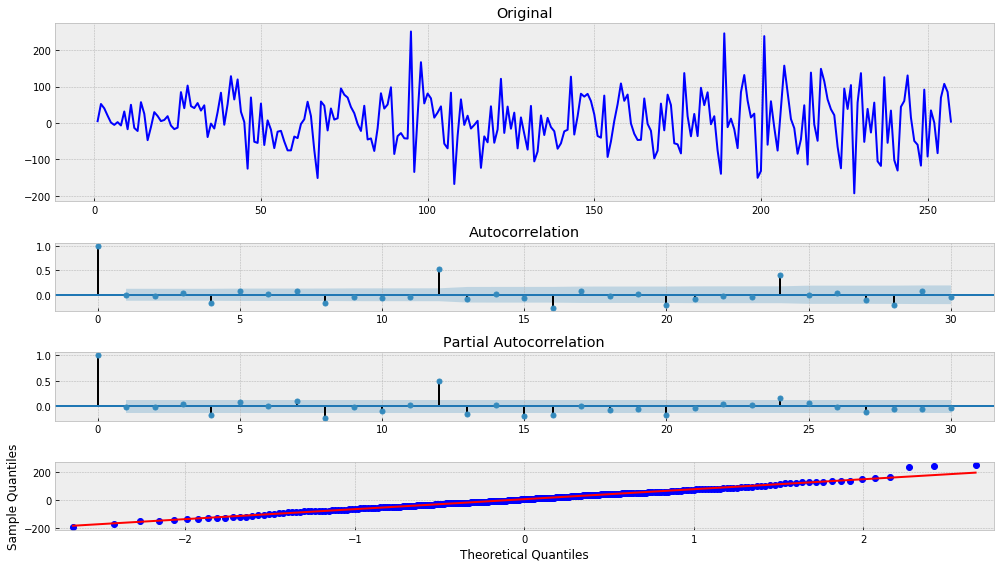

In [156]:
best_aic = np.inf 
best_order = None
best_mdl = None

for i in range(5):
    for d in range(5):
        for j in range(5):
            try:
                tmp_mdl = smt.ARIMA(train_nst, order=(i,d,j)).fit(method='mle', trend='nc')
                tmp_aic = tmp_mdl.aic
                if tmp_aic < best_aic:
                    best_aic = tmp_aic
                    best_order = (i, d, j)
                    best_mdl = tmp_mdl
            except: continue


print('aic: {:6.5f} | order: {}'.format(best_aic, best_order))


tsplot(best_mdl.resid, lags=30)

In [157]:
best_order, best_aic

((4, 1, 4), 2945.4072301245747)

In [158]:
len(train_nst)

258

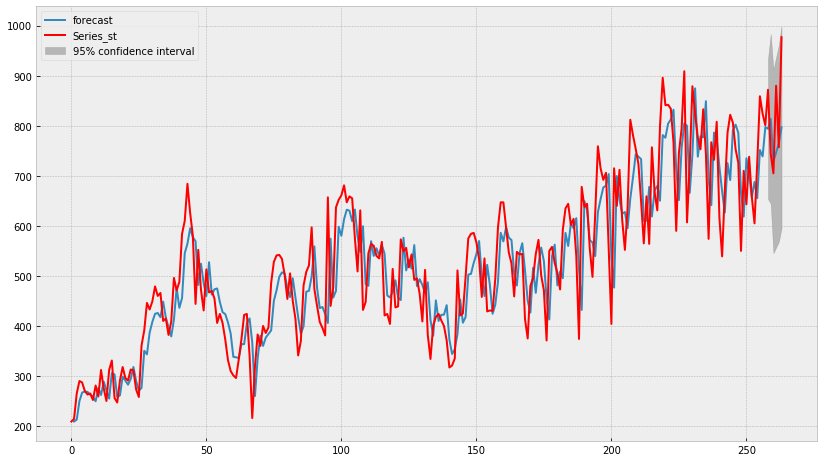

In [159]:
with plt.style.context('bmh'):
    plt.figure(figsize=(14,8))
    ax = plt.axes()
    best_mdl.plot_predict(1, len(train_nst)+5, plot_insample=False, ax=ax)
    plt.plot(series_nst, color='red', label='Series_st')
    plt.legend()
    plt.show()

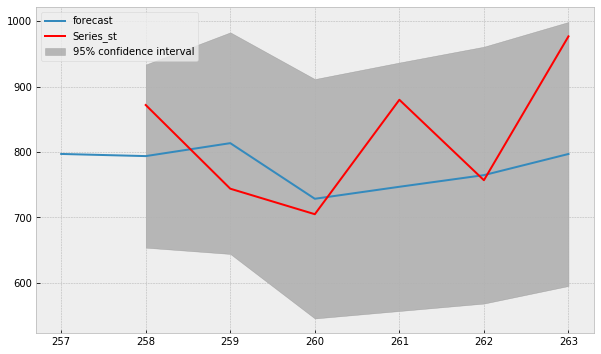

In [160]:
with plt.style.context('bmh'):
    plt.figure(figsize=(10,6))
    ax = plt.axes()
    best_mdl.plot_predict(len(train_nst)-1, len(train_nst)+5, plot_insample=False, ax=ax)
    plt.plot(series_nst[-6:], color='red', label='Series_st')
    plt.legend()
    plt.show()

In [161]:
test_nst

258    872
259    744
260    705
261    880
262    757
263    977
Name: Registrations, dtype: int64

In [163]:
predictions_arima = best_mdl.predict(1, len(train_nst)+5, typ='levels')

In [164]:
predictions_arima[-6:]

258    793.866873
259    813.674081
260    728.604529
261    746.948097
262    764.752769
263    797.113324
dtype: float64

In [166]:
arima_errors = mean_squared_error(test_nst, predictions_arima[-6:])
print(f'MSE на тестовом ряде для модели ARIMA и исходного ряда: {arima_errors:.2f}')

MSE на тестовом ряде для модели ARIMA и исходного ряда: 10273.09


Предсказания на оригинальном ряде оказались хуже, чем на стационарном.

#### 2.2. GARCH

In [187]:
# Now we can fit the arch model using the best fit arima model parameters
p_ = best_order[0]
o_ = best_order[1]
q_ = best_order[2]

# Using student T distribution usually provides better fit
am = arch_model(series_nst, p=p_, o=o_, q=q_, dist='StudentsT')
res = am.fit(update_freq=5, disp='off')
print(res.summary())

                      Constant Mean - GJR-GARCH Model Results                       
Dep. Variable:                Registrations   R-squared:                      -0.054
Mean Model:                   Constant Mean   Adj. R-squared:                 -0.054
Vol Model:                        GJR-GARCH   Log-Likelihood:               -1655.83
Distribution:      Standardized Student's t   AIC:                           3335.67
Method:                  Maximum Likelihood   BIC:                           3378.58
                                              No. Observations:                  264
Date:                      Sun, May 26 2019   Df Residuals:                      252
Time:                              15:04:12   Df Model:                           12
                                 Mean Model                                 
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
mu  

Results of Dickey-Fuller Test:
Test Statistic                  -1.225039
p-value                          0.662733
#Lags Used                      15.000000
Number of Observations Used    248.000000
Critical Value (1%)             -3.456996
Critical Value (5%)             -2.873266
Critical Value (10%)            -2.573019
dtype: float64


/home/sergey/anaconda3/lib/python3.7/site-packages/statsmodels/regression/linear_model.py:1283: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


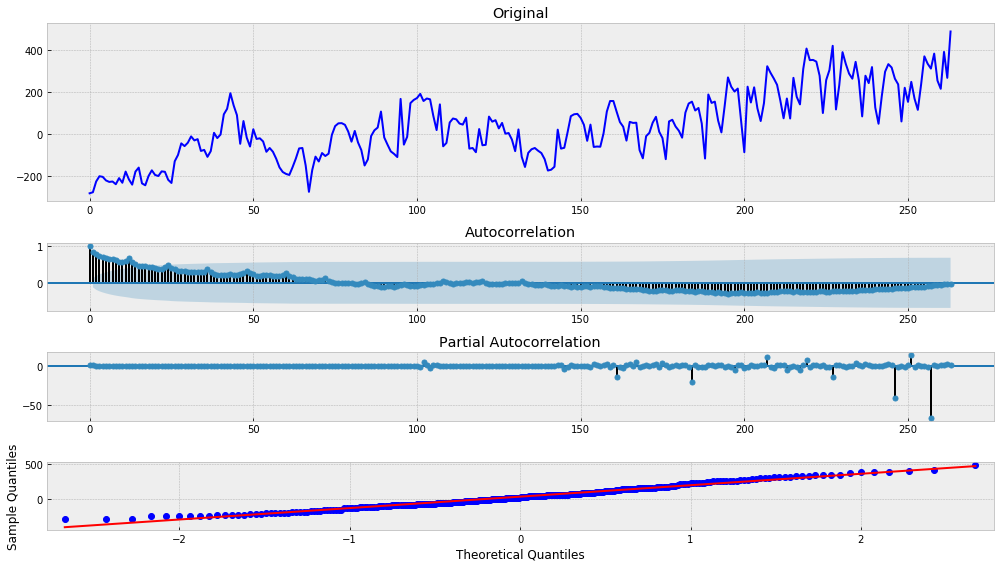

In [188]:
tsplot(res.resid)

Остатки нестационарны, требуется привести ряд к стационарному.